# Augraphy - Generate Shabby-pages example

In this example, [augraphy](https://github.com/sparkfish/augraphy) and  [shabby-pipeline](https://github.com/sparkfish/shabby-pages) are use to generate noisy images from the input [pdf](https://www.gutenberg.org/files/59248/59248-pdf.pdf) file.

In [ ]:
# Install augraphy in the system

!pip install git+https://github.com/sparkfish/augraphy


  Cloning https://github.com/sparkfish/augraphy to /tmp/pip-req-build-6_rairbe
  Running command git clone -q https://github.com/sparkfish/augraphy /tmp/pip-req-build-6_rairbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
  Created wheel for augraphy: filename=augraphy-7.0.0-py3-none-any.whl size=82941 sha256=95caf6111190f524a69d4ac0101cfcc78dfc0cb330936a1bd49a8c266918a682
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1tnk5sc/wheels/c0/b4/ea/15b2fdd6b43fa9f9961b0bc0eb235d87198c7f168edd90b347
Successfully built augraphy
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4

In [ ]:
# Download shabby-pages repository

import os 

# remove any existing folder (if there's any from the previous run)
if os.path.isdir("shabby-pages"):
  !rm -r shabby-pages

!git clone https://github.com/sparkfish/shabby-pages.git


Cloning into 'shabby-pages'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 209 (delta 41), reused 32 (delta 21), pack-reused 147
Receiving objects: 100% (209/209), 4.72 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
# Install pdf2image and their dependency (to convert pdf file into images)

!apt-get install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 1s (275 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# Download pdf document

if not os.path.isfile("59248-pdf.pdf"):
    !wget https://www.gutenberg.org/files/59248/59248-pdf.pdf

--2022-05-07 03:19:44--  https://www.gutenberg.org/files/59248/59248-pdf.pdf
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406488 (1.3M) [application/pdf]
Saving to: ‘59248-pdf.pdf’

59248-pdf.pdf       100%[===================>]   1.34M  2.27MB/s    in 0.6s    

2022-05-07 03:19:45 (2.27 MB/s) - ‘59248-pdf.pdf’ saved [1406488/1406488]



In [ ]:
# Convert pdf document into images

from pdf2image import convert_from_path, convert_from_bytes

images = convert_from_path("59248-pdf.pdf", dpi=150)


In [ ]:
# Import library from shabbypipeline

import importlib

shabbypipeline = importlib.import_module("shabby-pages.shabbypipeline")
get_pipeline = getattr(shabbypipeline ,"get_pipeline")


In [ ]:
# Create directory for converting pdf document's images

if os.path.isdir("images"):
    !rm -r images

os.makedirs("images/150dpi")

In [ ]:
# Convert and save pdf images into disk

import cv2
import numpy as np

for i, image in enumerate(images):
  cv2.imwrite("images/150dpi/image_"+str(i)+".png", np.asarray(image))


In [ ]:
# Create folders for training and test data

import random
import os
import shutil
from multiprocessing import Pool, cpu_count

for directory in ["train", "train_cleaned", "test", "test_cleaned"]:
    full_dir = "images/full/"+directory
    cropped_dir = "images/cropped/"+directory

    if not os.path.exists(full_dir):
        os.makedirs(full_dir)
    if not os.path.exists(cropped_dir):
        os.makedirs(cropped_dir)


In [ ]:
# Separate data into training and testing set

training_size = 0.7

all_images = os.listdir("images/150dpi")

num_cleans = len(all_images)
num_trains = int(num_cleans*training_size)
full_cleans = random.sample(all_images, num_cleans)
trains = random.sample(full_cleans, num_trains)

In [ ]:
# Initialize functions

# check if file name is in training set
def trainSplit(filename):
    if filename in trains:
        return True
    else:
        return False

# randomly choose patch of image from input image and return their box location
def choosePatch(img):
    x,y,c = img.shape

    max_x = x - 500
    max_y = y - 500

    left = random.randint(0,max_x)
    top = random.randint(0,max_y)
    right = left + 500
    bottom = top + 500

    return left,right,top,bottom

# run shabby-pipeline
def run_pipeline(filename):
    outputdir = "images/train" if trainSplit(filename) else "images/test"

    print("Processing "+filename)

    clean = cv2.imread("images/150dpi/"+filename)

    pipeline = get_pipeline()

    shabby = pipeline.augment(clean)["output"]

    left,right,top,bottom = choosePatch(clean)

    clean_patch = cv2.resize(clean[left:right,top:bottom], (400,400), interpolation = cv2.INTER_AREA)

    shabby_patch = cv2.resize(shabby[left:right,top:bottom], (400,400), interpolation = cv2.INTER_AREA)

    if outputdir == "images/train":
        shutil.copyfile("images/150dpi/{}".format(filename), "images/full/train_cleaned/{}".format(filename))
        cv2.imwrite("images/full/train/{}".format(filename), shabby)
        cv2.imwrite("images/cropped/train_cleaned/{}".format(filename), clean_patch)
        cv2.imwrite("images/cropped/train/{}".format(filename), shabby_patch)
    else:
        shutil.copyfile("images/150dpi/{}".format(filename), f"images/full/test_cleaned/{filename}")
        cv2.imwrite("images/full/test/{}".format(filename), shabby)
        cv2.imwrite("images/cropped/test_cleaned/{}".format(filename), clean_patch)
        cv2.imwrite("images/cropped/test/{}".format(filename), shabby_patch)


In [ ]:
# Download paper texture

import gdown
import zipfile

# get the paper textures
id = "1114s61-GmHbhIn8f9YNz6OwS3CwkOsIp"
gdown.download(id=id, output="paper_textures.zip", quiet=True)

# extract the zip
with zipfile.ZipFile("paper_textures.zip", 'r') as zip_ref:
    zip_ref.extractall()

# fix the directory name
os.rename("paper textures", "paper_textures")

# remove zip file
!rm paper_textures.zip

In [ ]:
# Run pipeline and apply augmentation in the images

num_cores = cpu_count()
p = Pool(num_cores)

p.map(run_pipeline, full_cleans, chunksize=10)

Processing image_359.png
Processing image_263.png
Processing image_3.png
Processing image_166.png
Processing image_4.png
Processing image_141.png
Processing image_338.png
Processing image_83.png
Processing image_433.png
Processing image_110.png
Processing image_78.png
Processing image_191.png
Processing image_288.png
Processing image_336.png
Processing image_280.png
Processing image_106.png
Processing image_407.png
Processing image_12.png
Processing image_138.png
Processing image_271.png
Processing image_57.png
Processing image_422.png
Processing image_43.png
Processing image_234.png
Processing image_215.png
Processing image_155.png
Processing image_121.png
Processing image_175.png
Processing image_118.png
Processing image_95.png
Processing image_397.png
Processing image_207.png
Processing image_437.png
Processing image_132.png
Processing image_190.png
Processing image_442.png
Processing image_268.png
Processing image_45.png
Processing image_401.png
Processing image_303.png
Processing 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

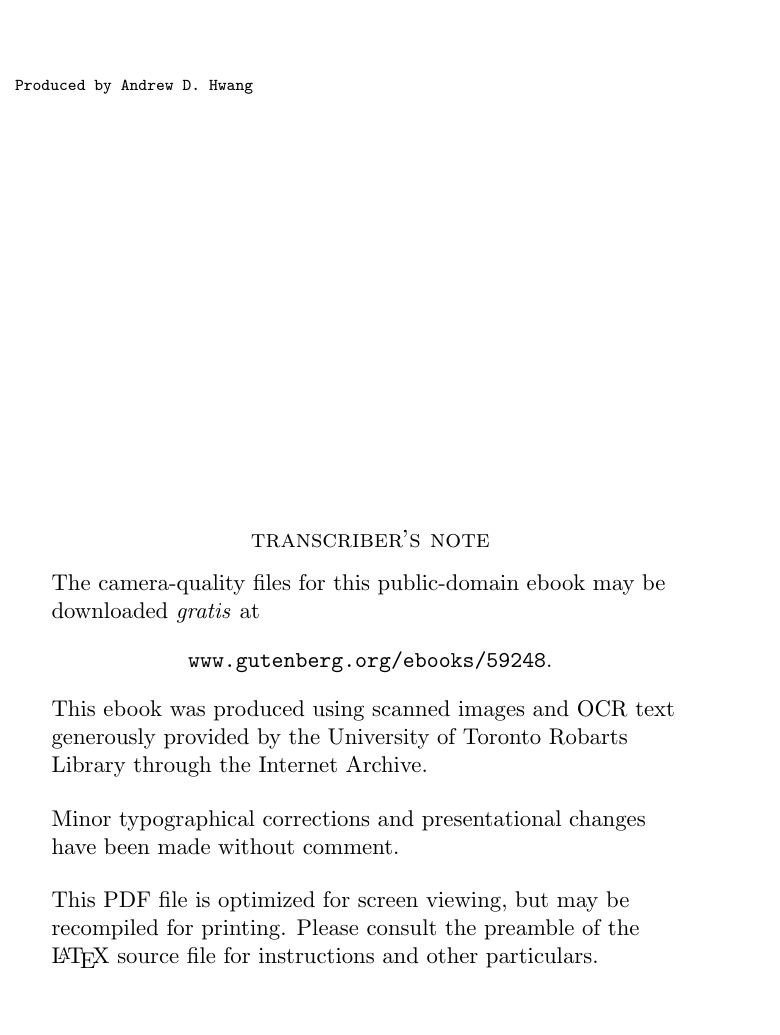

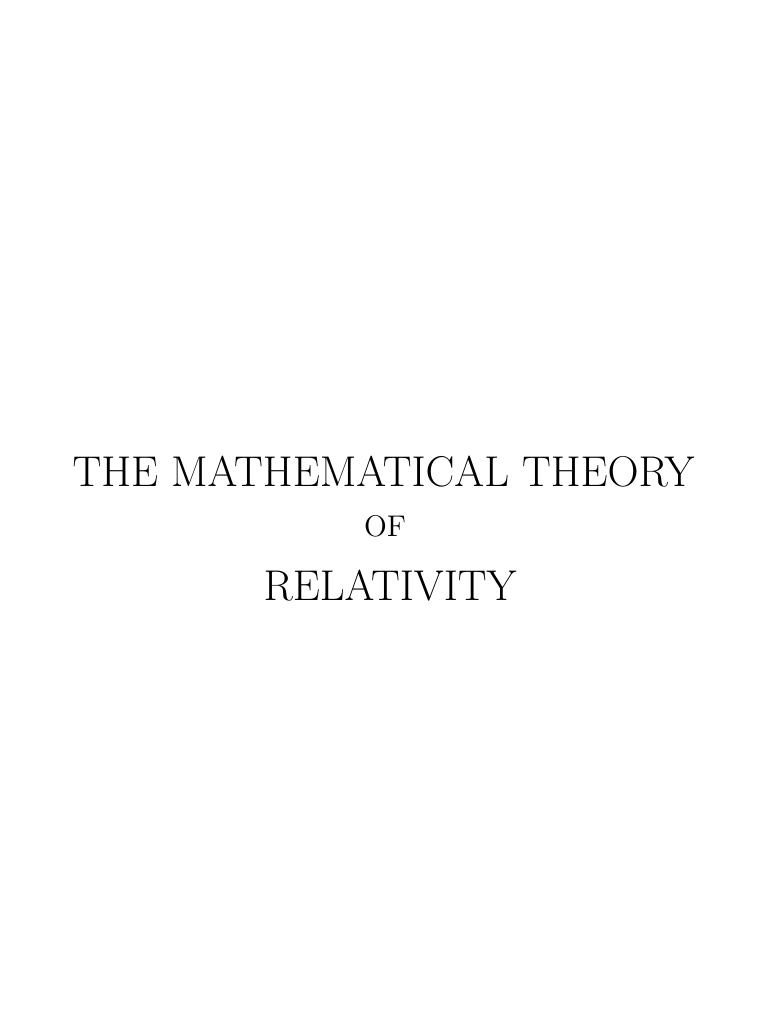

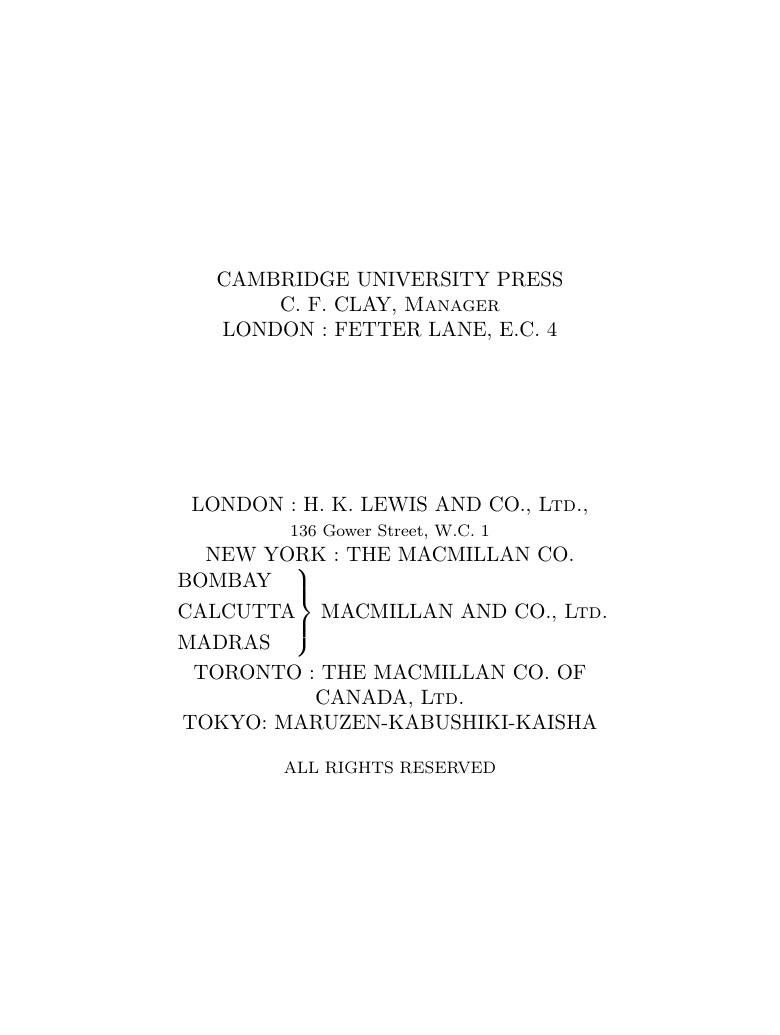

In [ ]:
# Display example of raw images

from IPython.display import Image, display

display(Image('images/150dpi/image_1.png'))
display(Image('images/150dpi/image_2.png'))
display(Image('images/150dpi/image_3.png'))


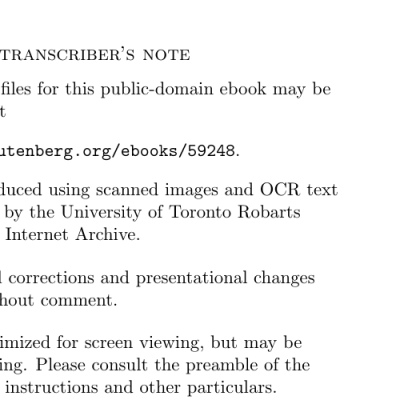

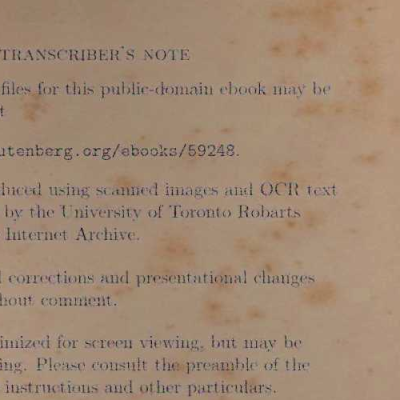

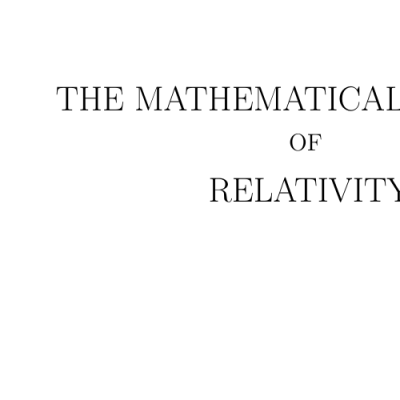

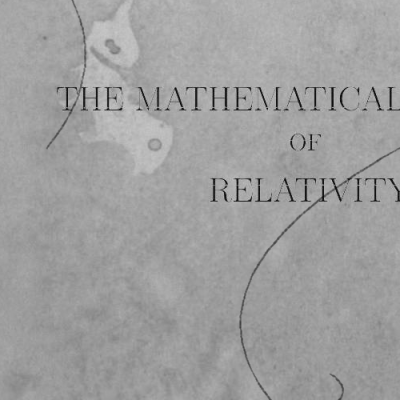

In [ ]:
# Display example of cropped clean and augmented image

display(Image('images/cropped/train_cleaned/image_1.png'))
display(Image('images/cropped/train/image_1.png'))

print(' ')

display(Image('images/cropped/train_cleaned/image_2.png'))
display(Image('images/cropped/train/image_2.png'))

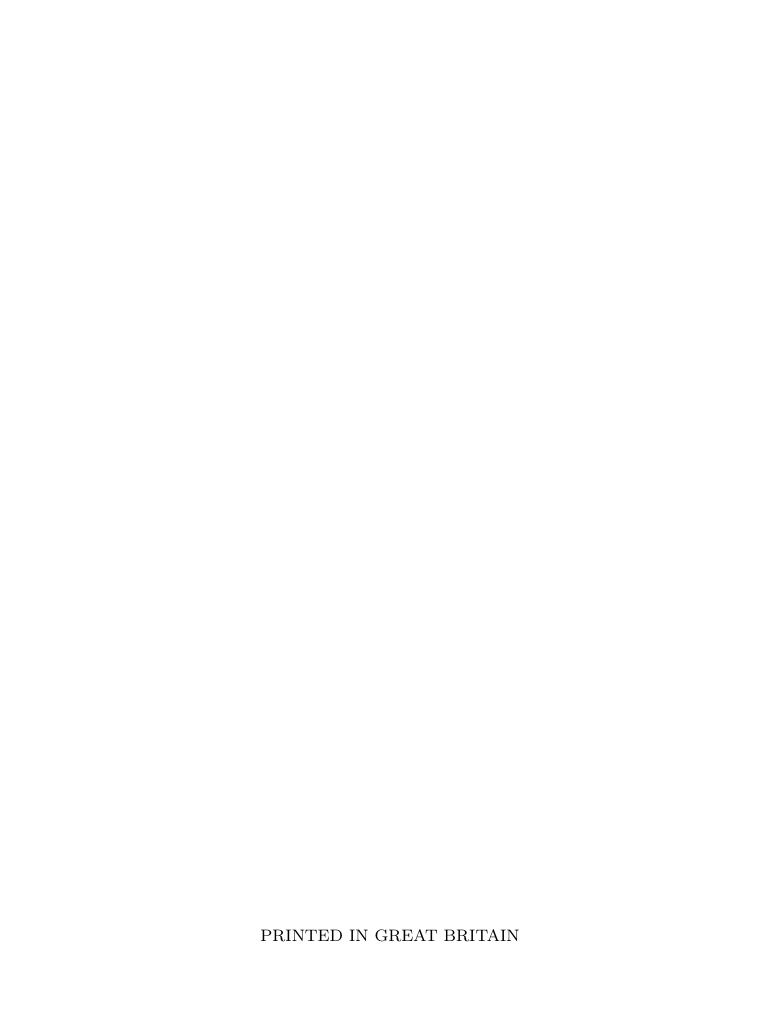

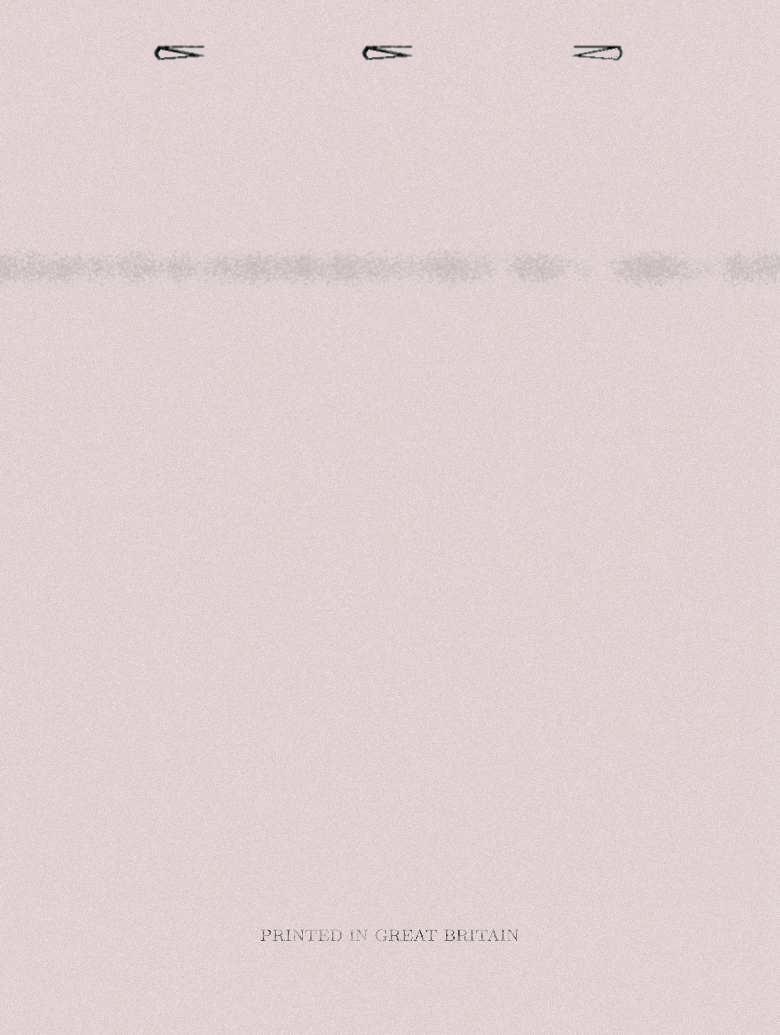

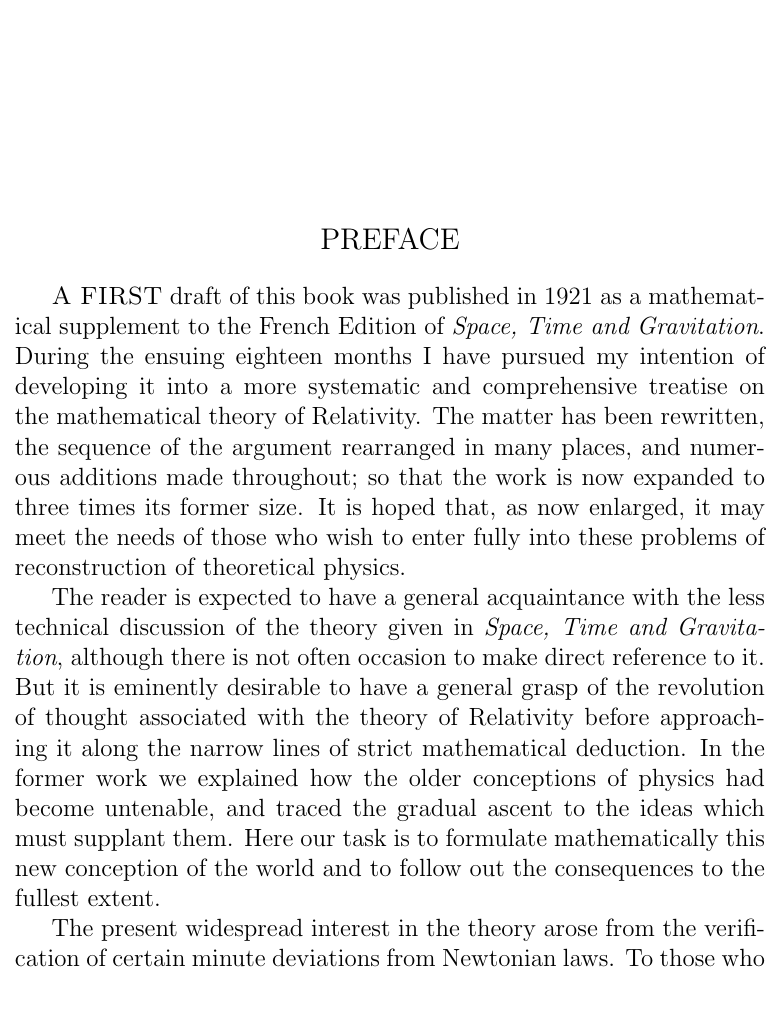

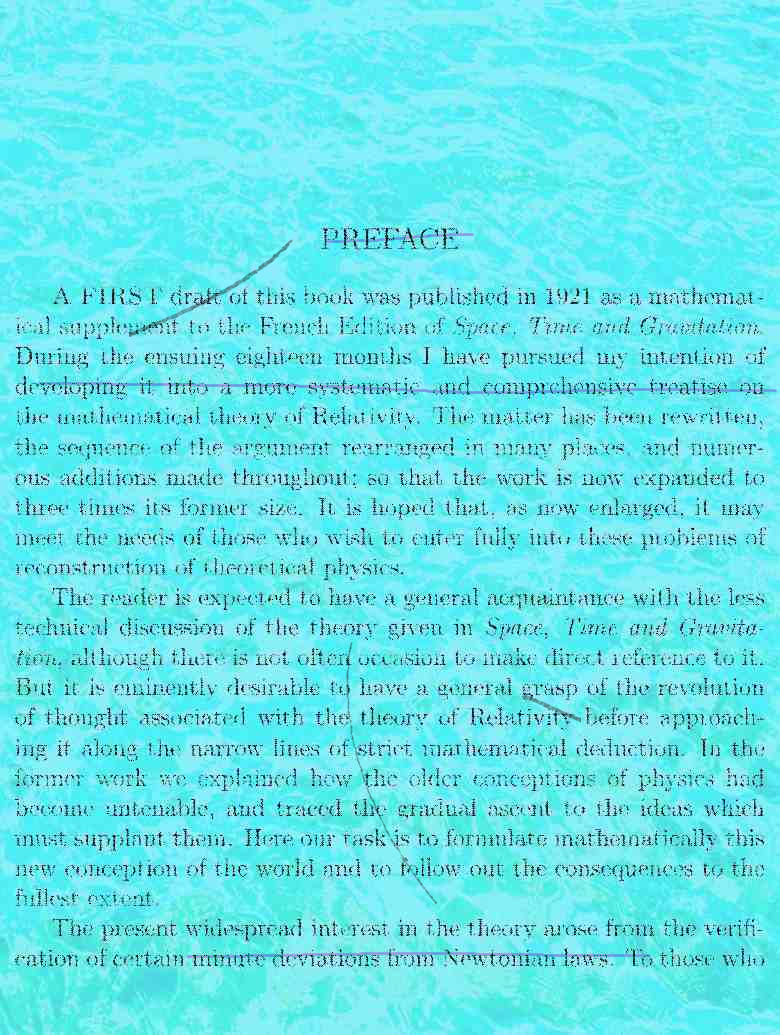

In [ ]:
# Display example of full clean and augmented image

display(Image('images/full/train_cleaned/image_5.png'))
display(Image('images/full/train/image_5.png'))

print(' ')

display(Image('images/full/train_cleaned/image_6.png'))
display(Image('images/full/train/image_6.png'))

In [ ]:
# Save raw input and augmented images into local disk

from google.colab import files

!zip -r images.zip images

files.download('images.zip')

  adding: images/ (stored 0%)
  adding: images/cropped/ (stored 0%)
  adding: images/cropped/train_cleaned/ (stored 0%)
  adding: images/cropped/train_cleaned/image_336.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_344.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_5.png (deflated 94%)
  adding: images/cropped/train_cleaned/image_363.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_39.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_214.png (deflated 15%)
  adding: images/cropped/train_cleaned/image_335.png (deflated 15%)
  adding: images/cropped/train_cleaned/image_266.png (deflated 16%)
  adding: images/cropped/train_cleaned/image_15.png (deflated 42%)
  adding: images/cropped/train_cleaned/image_169.png (deflated 15%)
  adding: images/cropped/train_cleaned/image_48.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_356.png (deflated 14%)
  adding: images/cropped/train_cleaned/image_117.png (deflated 13%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>